In [25]:
import pandas as pd
import re
from nltk.corpus import stopwords
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from transformers import XLNetTokenizer, XLNetModel
from sentence_transformers import SentenceTransformer

In [9]:
# Additional libraries for text preprocessing and feature engineering
import re
from nltk.corpus import stopwords
import numpy as np

In [10]:
# READ THE FILE INTO A DATAFRAME
df = pd.read_csv("../../Fake review detection dataset/Yelp Dataset Reduced.csv")

In [11]:
df.head()

,ID,USER_ID,PRODUCT_ID,RATING,DATE,LABEL,REVIEW_TEXT,AVERAGE_RATING,RATING_DEVIATION,TOTAL_PRODUCT_REVIEWS,...,RATING_CATEGORY,SINGLE_RATING_CATEGORY,REVIEW_COUNT_DATE,SAME_DATE_MULTIPLE_REVIEWS,MAX_USER_REVIEWS_DAY,TIMESTAMP_DIFFERENCE,AVERAGE_USER_REVIEW_LENGTH,TOTAL_USER_REVIEWS,PERCENTAGE_POSITIVE_REVIEWS,RATIO_POSITIVE_NEGATIVE
0,144828,66563,416,4,10-12-2014,-1,Great.....,3.767293,0.232707,2183,...,1,1,1,0,2,0 days,11.500000,2,100.0,6.157377
1,157607,74755,449,4,26-03-2013,1,My family and I had Bubby's brunch on a Saturd...,3.396552,0.603448,812,...,1,1,2,0,2,1723 days,724.666667,12,100.0,3.121827
2,70401,49165,237,3,11-10-2011,1,"I really like this place, but they need to get...",3.799003,0.799003,602,...,1,1,2,0,1,0 days,314.000000,1,100.0,6.082353
3,124810,75653,363,5,14-01-2014,1,This is one of my favorite places in the US. A...,3.990361,1.009639,2075,...,1,1,1,0,1,0 days,280.000000,1,100.0,9.121951
4,42068,32402,100,4,02-12-2014,1,Make sure you go with a small group of friends...,3.951812,0.048188,2677,...,1,1,2,0,1,398 days,255.666667,3,100.0,8.734545


In [12]:
# Define text preprocessing function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove punctuation and special characters
    text = re.sub(r"\s+", " ", text)  # Remove extra whitespace
    stop_words = set(stopwords.words("english"))
    text = " ".join([word for word in text.split() if word not in stop_words])    
    return text

df["REVIEW_TEXT"] = df["REVIEW_TEXT"].apply(preprocess_text)
text_data = df["REVIEW_TEXT"]
text_data_list = text_data.tolist()

In [7]:
df.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)
df['TIMESTAMP_DIFFERENCE'] = df['TIMESTAMP_DIFFERENCE'].str.replace(' days', '')
df['TIMESTAMP_DIFFERENCE'] = df['TIMESTAMP_DIFFERENCE'].astype(int)
numerical_data = df.drop(['ID', 'USER_ID', 'PRODUCT_ID', 'DATE', 'REVIEW_TEXT', 'LABEL'], axis=1)
label_data = df['LABEL']

In [13]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("all-MiniLM-L6-v2")
import time
# Our sentences to encode
print("Copying text data into sentences")
sentences = text_data_list

print("encoding sentences using model.encode")
# Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)


Copying text data into sentences
encoding sentences using model.encode


In [14]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(embeddings, label_data, test_size=0.2, stratify=label_data, random_state=42)

In [15]:
# # Oversampling
# adasyn = ADASYN(random_state=42)
# x_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

In [29]:
# Train an MLP classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
mlp_classifier.fit(X_train, y_train)

MLPClassifier(max_iter=1000, random_state=42)

In [17]:
# Make predictions on the test set
y_pred = mlp_classifier.predict(X_test)

In [18]:
# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8518054162487463
Confusion Matrix:
 [[  65  349]
 [ 242 3332]]
Classification Report:
               precision    recall  f1-score   support

          -1       0.21      0.16      0.18       414
           1       0.91      0.93      0.92      3574

    accuracy                           0.85      3988
   macro avg       0.56      0.54      0.55      3988
weighted avg       0.83      0.85      0.84      3988



In [20]:
# Predict probabilities for test data
y_pred_proba = mlp_classifier.predict_proba(X_test)[:, 1]

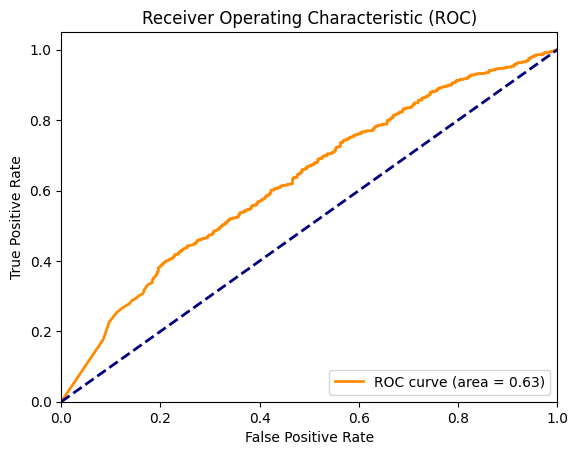

In [26]:
# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [27]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate sensitivity (true positive rate)
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])

# Calculate specificity (true negative rate)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

# Print sensitivity and specificity
print("Sensitivity (True Positive Rate):", sensitivity)
print("Specificity (True Negative Rate):", specificity)

Sensitivity (True Positive Rate): 0.932288752098489
Specificity (True Negative Rate): 0.1570048309178744
